In [2]:
# import load_model
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd

2023-01-15 01:13:27.399601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 01:13:27.491581: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-15 01:13:27.491594: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-15 01:13:27.937019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [37]:



# LOOKBACK_WINDOW = 100

# # create sequences from dataframe
# sequences = []
# for i in range(LOOKBACK_WINDOW - 1, len(df)):
#     sequences.append(df[i:i+LOOKBACK_WINDOW])

# # create numpy array from sequences
# sequences = np.array(sequences)




In [46]:
# first_item = sequences[0]
# first_item = pd.DataFrame(first_item)

original_items = ['event_time','original_open', 'original_close', 'original_high', 'original_low', 'original_volume']


# create nice comment that explains what this function does

# Receives an index and returns the data for the training and for the environment
def get_train_env_data(data):
    item = pd.DataFrame(data)
    return item[original_items], item.drop(original_items, axis=1)

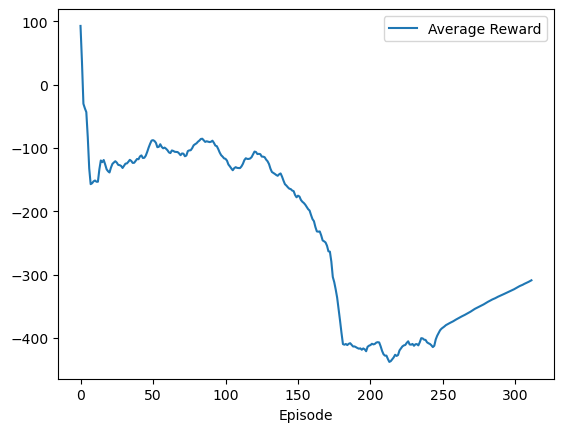

In [6]:
from matplotlib import pyplot as plt
# plot data from csv file
def plot_data(data):
    plt.plot(data)
    plt.xlabel("Episode")
    plt.legend(["Average Reward"])
    plt.show()

training_history = pd.read_csv("./Results/progress/train_05/reward_history_20230112-221809.csv")

plot_data(training_history['average_reward'])

In [55]:
def sequence_generator(data, batch_size, max_steps):
    for i in range(batch_size + 1, max_steps):
        yield data[i - batch_size:i]

In [62]:
def plot_buy_sell(data):
    plt.figure()

    width = .4
    width2 = .04

    #define colors to use
    col1 = 'green'
    col2 = 'red'

    for i in range(0, len(data)):
        item = data[i]
        item_candlestick = item[0]
        action = item[1]
        index = item[2]

        if action == ActionSpace.BUY:
            plt.plot(index, item_candlestick['original_close'], 'yo', markersize=5)
        elif action == ActionSpace.SELL:
            plt.plot(index, item_candlestick['original_close'], 'bo', markersize=4)

        if item_candlestick['original_close'] >= item_candlestick['original_open']:
            height = item_candlestick['original_close'] - item_candlestick['original_open']
            height_max = item_candlestick['original_high'] - item_candlestick['original_low']
            plt.bar(index, height, width, item_candlestick['original_open'], color=col1)
            plt.bar(index, height_max, width2, item_candlestick['original_open'], color=col1)
        else:
            height = item_candlestick['original_open'] - item_candlestick['original_close']
            height_max = item_candlestick['original_high'] - item_candlestick['original_low']
            plt.bar(index, height, width,  item_candlestick['original_close'], color=col2)
            plt.bar(index, height_max, width2,  item_candlestick['original_close'], color=col2)

    plt.ylabel("Price")

    plt.xlabel("Minutes")

    plt.show()



In [65]:
from enum import Enum
from tqdm import tqdm
class ActionSpace(Enum):
    BUY = 0
    HOLD = 1
    SELL = 2

# load AI model from Models
model = load_model("./Results/progress/train_15/models/model_100.h5")

# read data from file into pandas dataframe
df = pd.read_csv("./Data/dataset/VETUSDT.csv")


# loop through all sequences and predict buy hold or sell and put the results on a graph
buy_sells = []

LOOKBACK_WINDOW = 100
ITEMS = 1000


seq_gen = sequence_generator(df, LOOKBACK_WINDOW, ITEMS)

for i in tqdm(range(0, ITEMS - LOOKBACK_WINDOW)):
    try:
        item = next(seq_gen)
    except:
        break
    train, env = get_train_env_data(item)
    env = env.to_numpy()
    prediction = model.predict(env.reshape(1, LOOKBACK_WINDOW, 17), verbose=0)
    action = ActionSpace(np.argmax(prediction))
    buy_sells.append((train.iloc[-1], action, i))



100%|█████████▉| 899/900 [00:39<00:00, 22.74it/s]


In [67]:
%matplotlib tk
plot_buy_sell(buy_sells)

In [53]:
%load_ext tensorboard
%tensorboard --logdir Training/logs/fit